# Titanic

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [2]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
labels = ['Survived']

train_label = train_df['Survived']

In [3]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Drop 'Cabin' as it's very incompleted (204/890),
Embarked and Name also doesn't has anything to do with survival rate.

In [5]:
test_passenger_id = test_df['PassengerId']
dropped_columns = ['Fare', 'Cabin', 'Name', 'Embarked', 'PassengerId']
train_df = train_df.drop(dropped_columns, axis=1)
test_df = test_df.drop(dropped_columns, axis=1)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket
0,0,3,male,22.0,1,0,A/5 21171
1,1,1,female,38.0,1,0,PC 17599
2,1,3,female,26.0,0,0,STON/O2. 3101282
3,1,1,female,35.0,1,0,113803
4,0,3,male,35.0,0,0,373450


**Fill missing Age**

In [6]:
all_df = pd.concat([train_df, test_df], sort=False)
mean_age = int(round(all_df['Age'].mean()))
mean_age

train_df = train_df.fillna(value={'Age': mean_age})
test_df = test_df.fillna(value={'Age': mean_age})

## Categorical features

**Group ages**
Children <= 16
Adult 17 > x <= 50
Old 50 > x

In [7]:
def group_ages(df):
    binned_ages = pd.cut(df['Age'], [0, 16, 50, 90], labels=['children', 'adult', 'elder'])
    return df.join(pd.get_dummies(binned_ages))

train_df = group_ages(train_df)
train_df = train_df.drop(['Age'], axis=1)

test_df = group_ages(test_df)
test_df = test_df.drop(['Age'], axis=1)
train_df.head()

,Survived,Pclass,Sex,SibSp,Parch,Ticket,children,adult,elder
0,0,3,male,1,0,A/5 21171,0,1,0
1,1,1,female,1,0,PC 17599,0,1,0
2,1,3,female,0,0,STON/O2. 3101282,0,1,0
3,1,1,female,1,0,113803,0,1,0
4,0,3,male,0,0,373450,0,1,0


In [8]:
train_cat_df = train_df.select_dtypes(include=['object']).copy()
train_cat_df.head()

,Sex,Ticket
0,male,A/5 21171
1,female,PC 17599
2,female,STON/O2. 3101282
3,female,113803
4,male,373450


In [9]:
train_df.describe(include=['O'])

,Sex,Ticket
count,891,891
unique,2,681
top,male,CA. 2343
freq,577,7


Drop Ticket and Name as they have too many unique values

In [10]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)
train_df.head()

,Survived,Pclass,Sex,SibSp,Parch,children,adult,elder
0,0,3,male,1,0,0,1,0
1,1,1,female,1,0,0,1,0
2,1,3,female,0,0,0,1,0
3,1,1,female,1,0,0,1,0
4,0,3,male,0,0,0,1,0


**Sex**

In [11]:
def one_hot_sex(df):
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1}).astype(int)

one_hot_sex(train_df)
one_hot_sex(test_df)
train_df.head()

,Survived,Pclass,Sex,SibSp,Parch,children,adult,elder
0,0,3,0,1,0,0,1,0
1,1,1,1,1,0,0,1,0
2,1,3,1,0,0,0,1,0
3,1,1,1,1,0,0,1,0
4,0,3,0,0,0,0,1,0


**Pclass**

In [12]:
def one_hot_pclass(df):
    return df.join(pd.get_dummies(df['Pclass'], prefix='Pclass'))

In [13]:
train_df = one_hot_pclass(train_df)
train_df = train_df.drop(['Pclass'], axis=1)

test_df = one_hot_pclass(test_df)
test_df = test_df.drop(['Pclass'], axis=1)

train_df.head()

,Survived,Sex,SibSp,Parch,children,adult,elder,Pclass_1,Pclass_2,Pclass_3
0,0,0,1,0,0,1,0,0,0,1
1,1,1,1,0,0,1,0,1,0,0
2,1,1,0,0,0,1,0,0,0,1
3,1,1,1,0,0,1,0,1,0,0
4,0,0,0,0,0,1,0,0,0,1


## Feature Correlation

In [14]:
features = ['Sex', 'SibSp', 'Parch', 'children', 'adult', 'elder', 'Pclass_1', 'Pclass_2', 'Pclass_3']

all_df = pd.concat([train_df, test_df], sort=False)

for x in features:
    if all_df[x].dtype != 'float64' :
        print('Survival correlation by {}'.format(x))
        print(all_df[[x, 'Survived']].groupby(x, as_index=False).mean())
        print('\n')

Survival correlation by Sex
   Sex  Survived
0    0  0.188908
1    1  0.742038


Survival correlation by SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


Survival correlation by Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
7      9       NaN


Survival correlation by children
   children  Survived
0         0  0.362832
1         1  0.550000


Survival correlation by adult
   adult  Survived
0      0  0.469512
1      1  0.364512


Survival correlation by elder
   elder  Survived
0      0  0.386941
1      1  0.343750


Survival correlation by Pclass_1
   Pclass_1  Survived
0         0  0.305185
1         1  0.629630


Survival correlation by Pclass_2
   Pclass_2  Survived
0         0  0.360679
1         1  0.472826


Survival correlation by Pclass_3
   Pclass_3  Survi

In [15]:
def plot_stacked_bar(df, y):
    plt.subplot()
    plt.hist(x = [df[df['Survived'] == 1][y], df[df['Survived'] == 0][y]],
              stacked=True, color = ['g', 'r'], label = ['Survived', 'Dead'])
    plt.title('Survival by {}'.format(y))
    plt.xlabel(y)
    plt.ylabel('passengers')
    plt.legend()

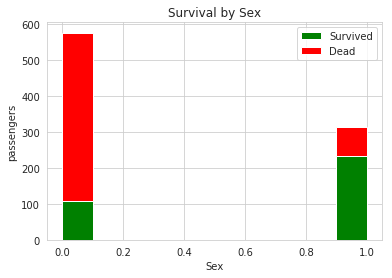

In [16]:
plot_stacked_bar(all_df, 'Sex')

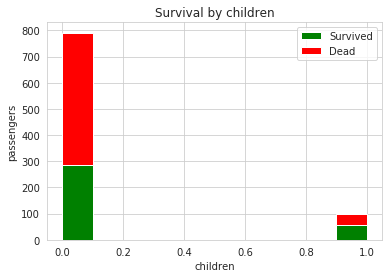

In [17]:
plot_stacked_bar(all_df, 'children')

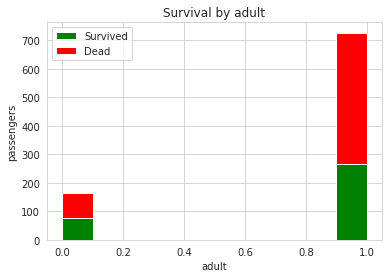

In [18]:
plot_stacked_bar(all_df, 'adult')

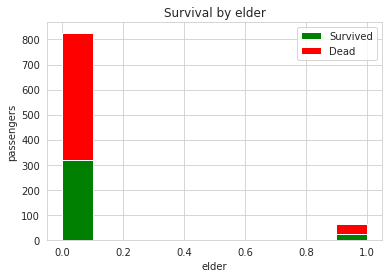

In [19]:
plot_stacked_bar(all_df, 'elder')

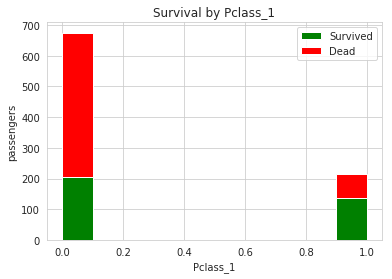

In [20]:
plot_stacked_bar(all_df, 'Pclass_1')

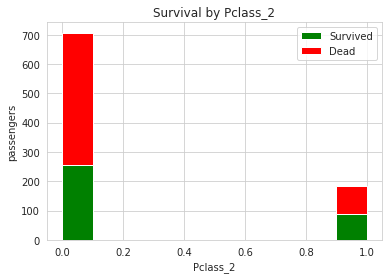

In [21]:
plot_stacked_bar(all_df, 'Pclass_2')

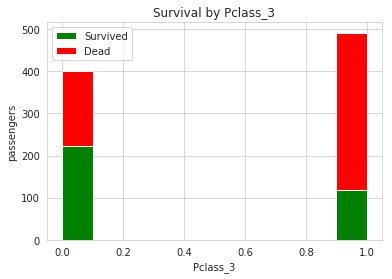

In [22]:
plot_stacked_bar(all_df, 'Pclass_3')

## Train model

In [23]:
train_df = train_df.drop(['Survived'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(train_df, train_label, test_size=0.2, random_state=42)

In [24]:
x_train.head()

,Sex,SibSp,Parch,children,adult,elder,Pclass_1,Pclass_2,Pclass_3
331,0,0,0,0,1,0,1,0,0
733,0,0,0,0,1,0,0,1,0
382,0,0,0,0,1,0,0,0,1
704,0,1,0,0,1,0,0,0,1
813,1,4,2,1,0,0,0,0,1


## Cross valiation

### Logistic Regression

In [40]:
# TODO: do cross validation and pick the best one with highest AUC between precision and recall

log_reg_model = LogisticRegression(solver='lbfgs', max_iter=200)
log_reg_model.fit(x_train, y_train)

log_reg_pred = log_reg_model.predict(x_test)
print(confusion_matrix(y_test, log_reg_pred))
print(classification_report(y_test, log_reg_pred))



[[91 14]
 [21 53]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       105
           1       0.79      0.72      0.75        74

   micro avg       0.80      0.80      0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



### SVM

In [39]:
svm_model = SVC(gamma='auto')
svm_model.fit(x_train, y_train)

svm_pred = svm_model.predict(x_test)
print(confusion_matrix(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

[[92 13]
 [20 54]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

   micro avg       0.82      0.82      0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



## Submit

In [41]:
test_df.reset_index()
pred = svm_model.predict(test_df)

In [32]:
submit = pd.DataFrame()
submit['PassengerId'] = test_passenger_id
submit['Survived'] = pred
submit.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [42]:
submit.to_csv('submit.csv', index=False)